# Assignment 4: Text and Sequence Data
# BA 64061-003
# Madeline Witzeman

# Loading and Preparing the IMDb dataset

In [1]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  3446k      0  0:00:23  0:00:23 --:--:-- 5264k


In [2]:
!rm -r aclImdb/train/unsup

Inspecting some of the data prior to modeling:

In [3]:
!cat aclImdb/train/pos/4077_10.txt

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy

## Based on the assignment instructions, I am validating on 10,000 samples (#3) and training on 100 samples (#2):

In [4]:
import os, pathlib, shutil, random

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
train_dir_2 = base_dir / "train2"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.4 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

for category in ("neg", "pos"):
    os.makedirs(train_dir_2 / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_train_samples = int(0.0067 * len(files))
    train_files = files[-num_train_samples:]
    for fname in train_files:
        shutil.move(train_dir / category / fname,
                    train_dir_2 / category / fname)

In [5]:
from tensorflow import keras
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
train_ds_2 = keras.utils.text_dataset_from_directory(
    "aclImdb/train2", batch_size=batch_size
)

Found 14900 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


## Displaying the shapes and data types of the first batch

In [6]:
for inputs, targets in train_ds_2:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b"This is why i so love this website ! I saw this film in the 1980's on British television. Over the years it is one i have wished i knew more about as it has stayed with me as one of the single most extraordinary things i have ever seen in my life. With barely a few key words to remember it by, i traced the film here, and much information, including the fact it's about to become an off-Broadway musical !<br /><br />Interestingly, unlike the previous comment maker, i do not remember finding this film sad, or exploitative. On the contrary, the extraordinary relationship between the mother and daughter stuck in the mind as a testimony of great strength, honour and dignity. Ironic you may think, considering the squalor of their lives. Maybe it's because i live in Britain, where fading grandeur has an established language in the lives of old money, where squalor is 

# Using the bag-of-words with multi-hot binary vectors approach to establish a baseline

## Preprocessing the datasets with a TextVectorization layer. Restricting the vocabulary to the top 10,000 words based on assignment instructions (#4):

In [7]:
from tensorflow.keras.layers import TextVectorization
text_vectorization = TextVectorization(
    output_mode="int",
)

In [8]:
text_vectorization = TextVectorization(
    max_tokens=10000,
    output_mode="multi_hot",
)
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_train_ds2 = train_ds_2.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

## Inspecting the output of the binary unigram dataset

In [9]:
for inputs, targets in binary_1gram_train_ds2:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32, 10000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor([1. 1. 1. ... 0. 0. 0.], shape=(10000,), dtype=float32)
targets[0]: tf.Tensor(0, shape=(), dtype=int32)


## The model-building utility

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(max_tokens=10000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

## Training and testing the binary unigram model

In [11]:
model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras",
                                    save_best_only=True)
]
model.fit(binary_1gram_train_ds2.cache(),
          validation_data=binary_1gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("binary_1gram.keras")
print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense (Dense)               (None, 16)                160016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
4/4 [==============================] - 4s 311ms/step - loss: 0.7049 - accuracy: 0.4800 - val_loss: 0.6833 - val_accuracy: 0.5618
Epoch 2/10
4/

By only using 100 training samples, this approach yields a validation accuracy of ~71.2% (at best) and a test accuracy of ~70.9%.

# Establishing a second model using an embedding layer

## Preparing integer sequence datasets. Based on the assignment instructions, I'm still limiting the vocabulary to the top 10,000 words (#4) and now cutting off the reviews after 150 words (#1):

In [12]:
from tensorflow.keras import layers

max_length = 150
max_tokens = 10000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_train_ds_2 = train_ds_2.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

## Building a sequence model with an embedding layer trained from scratch with masking enabled

In [13]:
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

In [40]:
import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds_2, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_7 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_6 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2634049 (10.05 MB)
Trainable params: 2634049 (10.05 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

I enabled masking with the embedded layer since it improved model performance in the textbook. This approach yields a validation accuracy of ~53.0% (at best) and a test accuracy of ~53.7%, which is worse than the baseline binary unigram model. I'm now going to see how it compares to the pretrained word embedding model training on only 100 samples.

# Establishing a third model using pretrained word embedding

In [15]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-04-25 04:38:58--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-04-25 04:38:58--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-04-25 04:38:59--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

## Parsing the GloVe word-embeddings file

In [16]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


## Preparing the GloVe word-embeddings matrix

In [17]:
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [18]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

## Building a model that uses a pretrained Embedding layer

In [41]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds_2, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_5 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_7 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2634049 (10.05 MB)
Trainable params: 2634049 (10.05 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

This approach yields a validation accuracy of ~54.0% (at best) and a test accuracy of ~54.7%, which is also worse than the baseline binary unigram model performance. This model performed very comparably to the model using an embedding layer trained from scratch. At times, the model with a pretrained word embedding layer performed better than the model with an embedding layer trained from scratch, and vice versa.

This makes sense given I am only training on a sample size of 100 movie reviews. When there isn't a large enough training sample to learn from the dataset itself, pretrained embedding layers can help improve model performance.

I'm going to alter the training sample size to see at what point the model utilizing the embedding layer trained from scracth notably outperforms the model utilizing the pretrained embedding layer.

# Increasing the training samples to 998 (almost 1,000)

In [20]:
import os, pathlib, shutil, random

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
train_dir_3 = base_dir / "train3"

for category in ("neg", "pos"):
    os.makedirs(train_dir_3 / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_train_samples_2 = int(0.067 * len(files))
    train_files_2 = files[-num_train_samples_2:]
    for fname in train_files_2:
        shutil.move(train_dir / category / fname,
                    train_dir_3 / category / fname)

In [21]:
from tensorflow import keras
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
train_ds_3 = keras.utils.text_dataset_from_directory(
    "aclImdb/train3", batch_size=batch_size
)

text_only_train_ds_3 = train_ds_3.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds_3)

Found 13902 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Found 998 files belonging to 2 classes.


# Establishing another model using an embedding layer training with 998 samples

I'm still keeping the validation samples to 10,000, cutting off reviews after 150 words, and considering only the top 10,000 words for this model and the next model.

In [22]:
from tensorflow.keras import layers

max_length = 150
max_tokens = 10000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds_3)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_train_ds_3 = train_ds_3.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [23]:
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

In [24]:
import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking_2.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds_3, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking_2.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2634049 (10.05 MB)
Trainable params: 2634049 (10.05 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

Training a model with an embedding layer (trained from scratch) yields a validation accuracy of ~76.8% (at best) and a test accuracy of ~74.7% when using 998 training samples. This is a significant improvement in performance compared to only training on 100 samples.

I'm now going to see how this performance compares to a model using a pretrained word embedding layer with 998 training samples.

# Establishing another model using pretrained word embedding with 998 training samples

In [25]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model_2.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds_3, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model_2.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2634049 (10.05 MB)
Trainable params: 2634049 (10.05 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

Training a model with a pretrained word embedding layer yields a validation accuracy of ~75.6% (at best) and a test accuracy of ~73.8% when using 998 training samples. Again, this is a significant improvement in performance compared to only training on 100 samples.

This model is still performing comparably to the model using an embedding layer trained from scratch, but appears to be performing worse overall when using 998 training samples (based on running both models multiple times at this training sample size). It appears it doesn't take a very large training sample size for the embedding layer model to outperform the pretrained word embedding layer model.

I'm now going to decrease the training samples to about 500 to see if that is sufficient to allow the embedding layer model to outperform the pretrained embedding layer model.

# Decreasing the training samples to 486 (about 500)

In [26]:
import os, pathlib, shutil, random

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
train_dir_4 = base_dir / "train4"

for category in ("neg", "pos"):
    os.makedirs(train_dir_4 / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_train_samples_3 = int(0.035 * len(files))
    train_files_3 = files[-num_train_samples_3:]
    for fname in train_files_3:
        shutil.move(train_dir / category / fname,
                    train_dir_4 / category / fname)

In [27]:
from tensorflow import keras
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
train_ds_4 = keras.utils.text_dataset_from_directory(
    "aclImdb/train4", batch_size=batch_size
)

text_only_train_ds_4 = train_ds_4.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds_4)

Found 13416 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Found 486 files belonging to 2 classes.


# Establishing another model using an embedding layer with around 500 training samples

Again, I'm still keeping the validation samples to 10,000, cutting off reviews after 150 words, and considering only the top 10,000 words for this model and the next model.

In [28]:
from tensorflow.keras import layers

max_length = 150
max_tokens = 10000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds_4)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_train_ds_4 = train_ds_4.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [29]:
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

In [30]:
import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking_3.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds_4, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking_3.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_6 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_4 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2634049 (10.05 MB)
Trainable params: 2634049 (10.05 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

Training a model with an embedding layer (trained from scratch) yields a validation accuracy of ~72.9% (at best) and a test accuracy of ~71.1% when using ~500 training samples. This is again a significant improvement in performance compared to only training on 100 samples, but not as good as training on close to 1,000 samples.

I'm now going to see how this performance compares to a model using a pretrained word embedding layer with around 500 training samples to see if only ~500 training samples is sufficient to enable the embedding layer model trained from scratch to outperform the pretrained word embedding model.

# Establishing a model using pretrained word embedding with around 500 training samples

In [31]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model_3.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds_4, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model_3.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_5 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_5 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2634049 (10.05 MB)
Trainable params: 2634049 (10.05 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

Training a model with a pretrained embedding layer yields a validation accuracy of ~71.4% (at best) and a test accuracy of ~68.8% when using ~500 training samples. This is again a significant improvement in performance compared to only training on 100 samples, but also not as good as training on close to 1,000 samples.

It appears that the model with the embedding layer trained from scratch overall outperforms the model with the pretrained layer, even with only ~500 training samples. It appears that it doesn't take a large training sample for the model with the embedding layer trained from scratch to outperform the model with the pretrained embedding layer on this dataset.

# Conclusion

In [32]:
import pandas

In [38]:
data_models = [['Bag-of-Words', 100], ['Embed from Scratch', 100], ['Pretrain Embed', 100], ['Embed from Scratch', 998], ['Pretrain Embed', 998], ['Embed from Scratch', 486], ['Pretrain Embed', 486]]

In [39]:
df = pandas.DataFrame(data_models, index=[1,2,3,4,5,6,7], columns=['Model Type', 'Train Sample Size'])
print(df)

           Model Type  Train Sample Size
1        Bag-of-Words                100
2  Embed from Scratch                100
3      Pretrain Embed                100
4  Embed from Scratch                998
5      Pretrain Embed                998
6  Embed from Scratch                486
7      Pretrain Embed                486


In [35]:
data_avgs = [[71.2, 70.9], [53.0, 53.7], [54.0, 54.7], [76.8, 74.7], [75.6, 73.8], [72.9, 71.1], [71.4, 68.8]]

In [36]:
df2 = pandas.DataFrame(data_avgs, index=[1,2,3,4,5,6,7], columns=['Validation Accuracy', 'Test Accuracy'])
print(df2)

   Validation Accuracy  Test Accuracy
1                 71.2           70.9
2                 53.0           53.7
3                 54.0           54.7
4                 76.8           74.7
5                 75.6           73.8
6                 72.9           71.1
7                 71.4           68.8


<Axes: title={'center': 'Model Performance'}, xlabel='Model Number', ylabel='Accuracy (%)'>

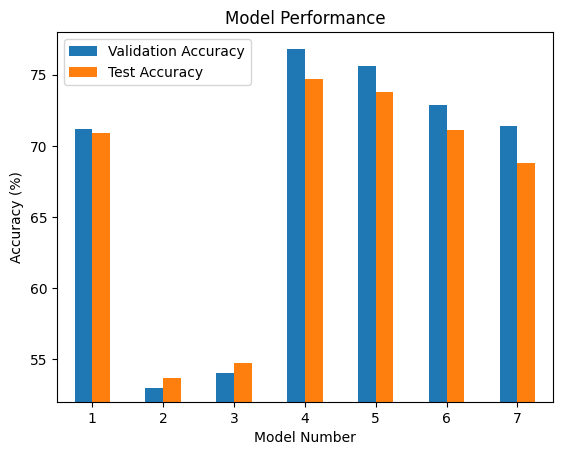

In [37]:
plot = df2.plot.bar(ylim=(52.0, 78.0), rot= 0, title="Model Performance")
plot.set_xlabel("Model Number")
plot.set_ylabel("Accuracy (%)")
plot

## In conclusion, when using only 100 training samples, the model with a pretrained embedding layer performed very comparably to the model with an embedding layer trained from scratch, and at times, performed better than the embedding layer model trained from scratch. The model with a pretrained embedding layer yielded about 54.0% validation accuracy and 54.7% test accuracy compared to the embedding model trained from scratch which yielded about 53.0% validation accuracy 53.7% test accuracy.

## When increasing the training sample size to 998, the model with an embedding layer trained from scratch outperformed the model with a pretrained embedding layer. The model with an embedding layer trained from scratch yielded a validation accuracy of ~76.8% and a test accuracy of ~74.7% compared to the model with a pretrained embedding layer which resulted in a validation accuracy of ~75.6% and a test accuracy of ~73.8%. Both of these models performed significantly better at 1,000 training samples vs. the initial 100 training samples.

## After seeing that the model with an embedding layer trained from scratch outperformed the model with a pretrained embedding layer at around 1,000 training samples, I decreased the number of training samples to 486 (roughly half) to see if this was enough samples to allow the embedding layer trained from scratch to outperform the pretrained embedding layer. It appears that roughly 500 training samples is enough for the model with the embedding layer trained from scratch to perform better (validation accuracy of ~72.9%, test accuracy of ~71.1%). This is in comparison to the model with a pretrained embedding layer, which resulted in a validation accuracy of ~71.4% and a test accuracy of ~68.8%. It appears that it doesn't take a large training sample for the model with the embedding layer trained from scratch to outperform the model with the pretrained embedding layer on this dataset.

## Lastly, the bag-of-word model displayed great potential, performing surprisingly well at only 100 training samples (71.2% validation accuracy, 70.9% test accuracy). Because this assignment was focused on models using embedding layers trained from scratch vs. models using pretrained embedding layers, I didn't attempt the bag-of-word approach on larger sample sizes, but I'm confident it would perform very well on a larger sample given how well it performed at only 100 training samples.